In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

![img](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

## Data Information
+ application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
+ bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
+ bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
+ previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
+ POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
+ credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
+ installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

print(app_train.shape)
print(app_test.shape)

(307511, 122)
(48744, 121)


## 1. TARGET
 + 0: loan was repaid
 + 1: loan was not repaid
 
&rarr; **Highly imbalaced**

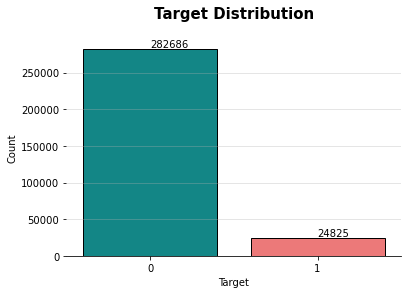

In [3]:
targets = pd.DataFrame(app_train['TARGET'].value_counts().reset_index())
targets['prop'] = targets['TARGET']/app_train.shape[0]

plt.figure(figsize = (6, 4))
ax = plt.subplot(1, 1, 1)
sns.barplot(targets['index'], targets['TARGET'], palette = ['#009999', '#ff6666'], edgecolor = 'k')
plt.text(0, targets['TARGET'][0]+2000, targets['TARGET'][0])
plt.text(1, targets['TARGET'][1]+2000, targets['TARGET'][1])
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.title('Target Distribution', fontweight = 'bold', fontsize = 15, pad = 20)
plt.xlabel('Target'); plt.ylabel('Count')
plt.show()

## 2. Missing values
결측값(missing value)의 비율이 최대 약 69%로 해당 변수들을 drop할 경우 데이터 손실이 다수 발생할 수 있다. 따라서 imputation을 하거나 그대로 남겨둔다.

In [4]:
missing = pd.Series(app_train.isna().sum().sort_values(ascending = False))
missing = missing[missing > 0]
missing = missing/len(app_train)
missing

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 67, dtype: float64

## 3. Data Information

1. Object type
 - 총 16개
 - 모두 범주형 변수
 - OCCUPATION_TYPE, ORGANIZATION_TYPE 변수는 범주의 수가 매우 많음(20개 이상)
 - XGBoost, LightGBM 같은 모델에서는 결측값을 알아서 독립적인 범주로 인식함

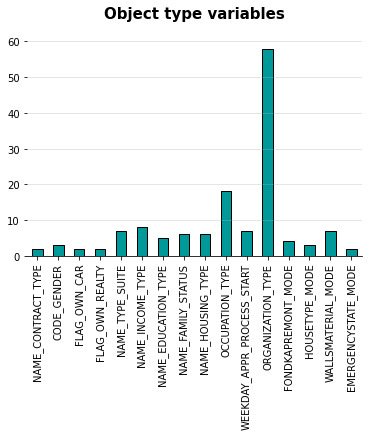

In [5]:
ax = app_train.select_dtypes('object').nunique().plot.bar(color = '#009999', edgecolor = 'k')

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('Object type variables', fontweight= 'bold', fontsize = 15, pad = 20)
plt.show()

2. Continuous variable
 - 총 65개
 - 모두 normalized 되어있음(Data description 참고)

In [6]:
app_train.select_dtypes('float')

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,NaN,1.0,0.083037,0.262949,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,NaN,2.0,0.311267,0.622246,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,26.0,1.0,NaN,0.555912,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,NaN,2.0,NaN,0.650442,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,NaN,1.0,NaN,0.322738,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,157500.0,254700.0,27558.0,225000.0,0.032561,-8456.0,NaN,1.0,0.145570,0.681632,...,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,NaN,NaN,NaN
307507,72000.0,269550.0,12001.5,225000.0,0.025164,-4388.0,NaN,1.0,NaN,0.115992,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
307508,153000.0,677664.0,29979.0,585000.0,0.005002,-6737.0,NaN,1.0,0.744026,0.535722,...,0.0,6.0,0.0,-1909.0,1.0,0.0,0.0,1.0,0.0,1.0
307509,171000.0,370107.0,20205.0,319500.0,0.005313,-2562.0,NaN,2.0,NaN,0.514163,...,0.0,0.0,0.0,-322.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# check NA
app_train.select_dtypes('float').isna().sum().sort_values(ascending = False)

COMMONAREA_AVG                214865
COMMONAREA_MEDI               214865
COMMONAREA_MODE               214865
NONLIVINGAPARTMENTS_MODE      213514
NONLIVINGAPARTMENTS_AVG       213514
                               ...  
DAYS_LAST_PHONE_CHANGE             1
DAYS_REGISTRATION                  0
REGION_POPULATION_RELATIVE         0
AMT_CREDIT                         0
AMT_INCOME_TOTAL                   0
Length: 65, dtype: int64

3. Integer variables (nominal)
 - 총 41개(TARGET 포함)
 - YES/NO 변수들
 - 각 변수에 결측값 없음

In [8]:
app_train.select_dtypes(np.int64)

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,-9461,-637,-2120,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-1188,-291,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-225,-2531,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-3039,-2437,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3038,-3458,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,-9327,-236,-1982,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,-20775,365243,-4090,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,0,-14966,-7921,-5150,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,-11961,-4786,-931,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# summarize nominal variables
app_train.select_dtypes(np.int64).describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH variables have negatvie values.

In [13]:
app_train['DAYS_BIRTH'] = -1 * app_train['DAYS_BIRTH']
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH']/365

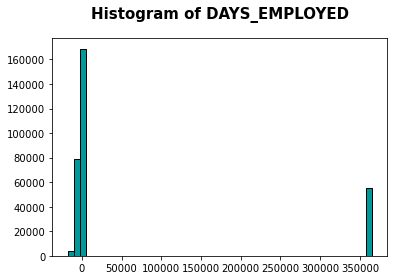

In [28]:
plt.hist(app_train['DAYS_EMPLOYED'], color = '#009999', edgecolor = 'k', bins = 50)
plt.title('Histogram of DAYS_EMPLOYED', fontsize = 15, fontweight = 'bold', pad = 20)
plt.show()

In [35]:
num_out = app_train[app_train['DAYS_EMPLOYED'] == 365243].shape[0]
print('The number of outliers in DAYS_EMOLOYED variable: ', num_out)
print('Percentage of outliers in DAYS_EMOLOYED variable: ', np.round(num_out/app_train.shape[0], 4))


# replace outliers with NaN
app_train['DAYS_EMPLOYED'].replace({365243, np.nan}, inplace = True)

The number of outliers in DAYS_EMOLOYED variable:  55374
Percentage of outliers in DAYS_EMOLOYED variable:  0.1801


In [20]:
app_train['DAYS_ID_PUBLISH'] = -1*app_train['DAYS_ID_PUBLISH']